In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# CONSTANTS
EPOCHS = 4000
EPS = 0.00000005  # random epsilon

# save the mu and sigma values for normalizing test data later
saved_z_scale_values = {}

In [ ]:
# Loads a data file from a provided file location.
def load_data(path):
    loaded_data = pd.read_csv(path)
    return loaded_data

# Implements dataset preprocessing, with boolean options to either normalize the data or not, 
# and to either drop the sqft_living15 column or not.
#
# Note that you will call this function multiple times to generate dataset versions that are
# / aren't normalized, or versions that have / lack sqft_living15.
#
# Data can be training or validation data -- training = True if training
def preprocess_data(data, normalize, drop_sqft_living15, training):
    # PART 0a - remove ID col
    data_without_id = data.drop("id", axis=1)
    # print("Dropped ID column", data_without_id.shape)

    # PART 0b - split 'date' into 'year', 'month', 'day'
    date_strings_DF = data_without_id['date']
    date_strings_array = date_strings_DF.values
    # print("Created date_strings_array", date_strings_array[:3])

    # use python list comprehension to apply the .split("/") function to each entry in date_strings_array:
    date_substrings_nested_list = [date.split("/") for date in date_strings_array]
    # print("Split each entry in date_strings_array", date_substrings_nested_list[:3])

    # [int(d_substring) for d_substring in date]    -  casts each entry in date to a string.
    # ... for date in date_substrings_nested_list]  -  causes date to iterate through every entry in date_substrings_nested_list
    date_integers_nested_list = [[int(d_substring) for d_substring in date] for date in date_substrings_nested_list]
    # print("Cast each date into a date", date_integers_nested_list[:3])

    # First, convert the nested list into a DataFrame with the appropriate column names:
    date_integers_DF = pd.DataFrame(date_integers_nested_list, columns=["month", "day", "year"])
    # print("Created new date df", date_integers_DF.shape)

    # Insert the new pandas columns into the old DataFrame:
    data_with_integer_dates = data_without_id.join(date_integers_DF)
    # print("Joined the date df with original df", data_with_integer_dates.shape)

    # Delete the old date column:
    data_with_integer_dates = data_with_integer_dates.drop("date", axis=1)
    # print("Deleted old date column", data_with_integer_dates.shape)

    # PART 0c - add dummy feature with constant 1 value
    data_with_dummy = data_with_integer_dates.copy()
    data_with_dummy.insert(1, "W0", np.ones(len(data_with_integer_dates)), True)
    # print("Added dummy feature", data_with_dummy.shape)

    # PART 0d - add age_yr_renovated
    data_with_dummy['age_since_renovated'] = data_with_dummy.apply(
        (lambda r: r['year'] - (r['yr_built'] if r['yr_renovated'] == 0 else r['yr_renovated'])), axis=1)
    data_without_yr_renovated = data_with_dummy.drop("yr_renovated", axis=1)
    # print("Added age_since_renovated", data_with_dummy.shape)

    preprocessed_data = data_without_yr_renovated

    # Normalization helper function
    def z_score_standardization(col, series):
        #reuse saved_z_scale_values the values for validation data
        mu = series.mean()
        sigma = series.std()
        if training == True:
            saved_z_scale_values[col] = [mu,sigma]
        else:
            mu, sigma = saved_z_scale_values[col]
        return (series - mu) / sigma

    # PART 0e - normalize features (if normalize is True)
    if normalize == True:
        for col in preprocessed_data.columns:
            if col != 'waterfront' and col != 'price' and col != 'W0':
                preprocessed_data[col] = z_score_standardization(col, preprocessed_data[col])
        # print("Normalized data", preprocessed_data.shape)

    # Part 2b - remove redundant feature sqft_living15
    if drop_sqft_living15 == True:
        preprocessed_data.drop("sqft_living15", axis=1, inplace=True)

    return preprocessed_data

# to keep track of w order and ensure they have the same mapping
# let's order the columns of X ourselves
X_COLS = [
    'W0',
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'sqft_above',
    'sqft_basement',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'yr_built',
    'zipcode',
    'lat',
    'long',
    'sqft_living15',
    'sqft_lot15',
    'month',
    'day',
    'year',
    'age_since_renovated'
]  # remove yr_renovated and price

# data - input dataframe with both x and y
# returns a numpy X matrix of Nxd (N = samples, d = variables) and y N-vector (each n in N price)
def split_df(data, use_cols=X_COLS):
    # get the X matrix and y vector 
    X = pd.DataFrame(data, columns=use_cols).to_numpy()
    y = pd.DataFrame(data, columns = ['price']).to_numpy()
    return X, y

In [ ]:
# calculate mse
def mse(N, y_hat, y):
    ls = (1.0 / N) * np.linalg.norm(y_hat - y, 2)
    return ls


# runs a prediction to get the output on a set of weights 
def predict(X, w):
    return np.matmul(X, w)


# weights should store the per-feature weights of the learned linear regression.
# losses should store the sequence of MSE losses for each epoch of training, which you will then plot.
def gd_train(X, y, lr, log=True):
    did_diverge = False
    N, d = X.shape  # get samples and variables
    # column vec of weights
    w = np.zeros((d, 1), np.float32)
    
    # run through the dataset EPOCHS times
    losses = []
    last_mse = 1000000.0
    for e in range(EPOCHS):
        # initially calculating mse before applying gradient
        train_mse = mse(N, predict(X, w), y)
        losses.append(float(train_mse)) # adding losses
        
        # check if below eps for the mse on all weights
        if np.abs(last_mse - train_mse) <= EPS:
            if log:
                print(f'MSE {train_mse} below {EPS}. Converged. Exiting...') 
            did_diverge = False
            break
        elif (train_mse - last_mse) > 1000*EPS:
            if log:
                print(f'MSE increased from {last_mse} to {train_mse}. Diverged. Exiting...')
            did_diverge = True
            break
        
        # split up mats for gradient calc
        XTXw = np.matmul(X.T, np.matmul(X, w))  # X^T . X . w
        XTy = np.matmul(X.T, y)  # X^T . y
        yTy = np.matmul(y.T, y)  # y^T * y
        
        # calculate the gradient
        grad = (1.0 / N) * (2.0 * XTXw - 2.0 * XTy)
        
        # update weights with learning rate
        w -= lr * grad
        last_mse = train_mse  # update last_mse for recalc
    
    return w, losses, did_diverge

In [ ]:
# Generates and saves plots of the training loss curves. Note that you can interpret losses as a matrix
# containing the losses of multiple training runs and then put multiple loss curves in a single plot.
# losses = [[losses1], [losses2], [losses3]...]
def plot_losses(losses, learning_rates):
    plt.rcParams['figure.figsize'] = [15, 8]
    for i in range(len(losses)):
        epochs = np.arange(0, len(losses[i]), 1)
        plt.plot(epochs, losses[i], label=f'LR {learning_rates[i]}')
    # plt.ylim(0, 0.5)
    plt.xlabel('EPOCHS')
    plt.ylabel('MSE')
    plt.title('Convergence plot of various LR') 
    plt.legend()
    plt.savefig('plot_1a.png')
    plt.show()

In [ ]:
# Part 0  : Data preprocessing.
train_data = load_data("IA1_train.csv")
print("Before processing:", train_data.shape)
print(train_data.columns)

# preprocess training data: normalize, don't remove sqft_living15, and save the z scaling mu and sigma values
train_data = preprocess_data(train_data, True, False, True)
print("After processing:", train_data.shape)
print(train_data.columns)

Before processing: (8000, 21)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')
After processing: (8000, 23)
Index(['bedrooms', 'W0', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'price', 'month', 'day', 'year', 'age_since_renovated'],
      dtype='object')


MSE increased from 0.07165879678783034 to 0.24350086243266683. Diverged. Exiting...
MSE 0.021695410903595422 below 5e-08. Converged. Exiting...
MSE 0.02186838822416733 below 5e-08. Converged. Exiting...
MSE 0.02197933623105985 below 5e-08. Converged. Exiting...


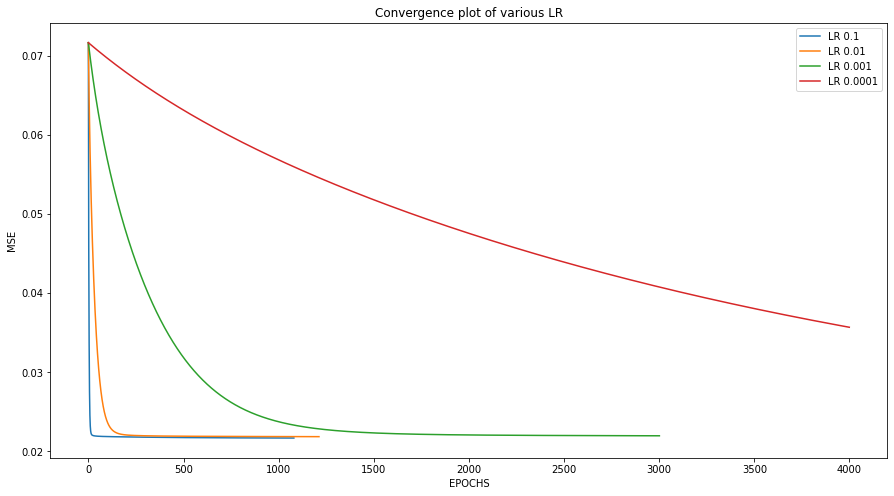

In [ ]:
# Part 1 . Implement batch gradient descent and experiment with different learning rates.
X, y = split_df(train_data)

training_losses = []
learning_rates = []
good_weights = []

# Trying learning rates of 10^-i for i=0,1,2,3,4
for m in range(5):
    lr = np.power(10.0, -m)
    weights, losses, did_diverge = gd_train(X, y, lr)
    
    # Add to plot data if curve did not diverge
    # and save the weights for validation data
    if not did_diverge:
        training_losses.append(losses)
        learning_rates.append(lr)
        good_weights.append(weights)
    
# Plot all curves that did not diverge
plot_losses(training_losses, learning_rates)
    

validation_losses [0.04776403607033666, 0.0486430249254479, 0.04892603677622165, 0.07580273274093179]


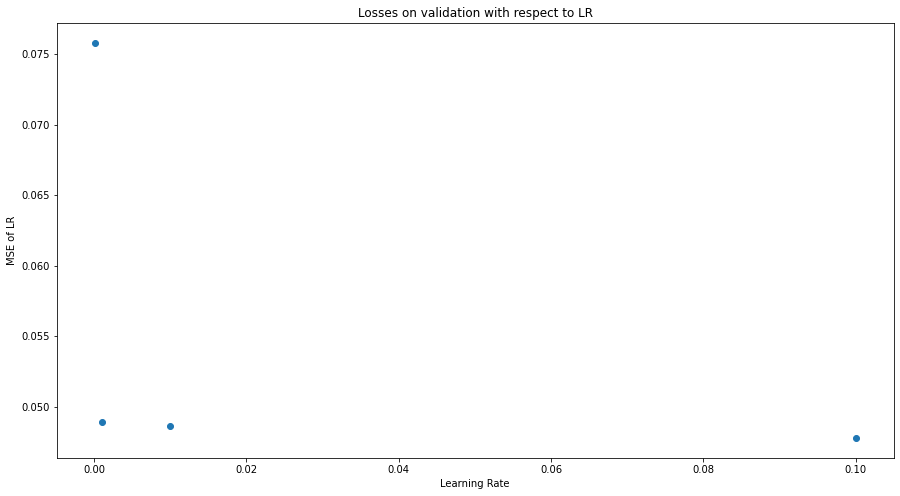

In [ ]:
# Part 1 b. For each learning rate that did not diverge, compute and report the MSE of final model on the validation data.

#loading validation data:

validation_data = load_data("IA1_dev.csv")
#print("Before processing:", validation_data.shape)
#print(validation_data.columns)

# preprocess validation data: normalize, don't remove sqft_living15, and use saved mu and sigma values
validation_data = preprocess_data(validation_data, True, False, False)
#print("After processing:", validation_data.shape)
#print(validation_data.columns)
#print(validation_data)

# the model == the trained weights

# mse for not divergent
X, y = split_df(validation_data)

# Predict using best training weights found for each learning rate
validation_losses = []

#print("good_weights",good_weights)

best_weights = []
lowest_mse = 1000000.0

for w in good_weights:
    y_hat = predict(X, w)
    # calculate MSE
    N = X.shape[0]
    validation_mse = float(mse(N, y_hat, y))
    validation_losses.append(validation_mse)
    if validation_mse < lowest_mse:
        lowest_mse = validation_mse
        best_weights = w

print("validation_losses", validation_losses)

# Plot the validation losses
plt.scatter(learning_rates, validation_losses)
plt.title("Losses on validation with respect to LR")
plt.xlabel("Learning Rate")
plt.ylabel("MSE of LR")
plt.show()


In [ ]:
# Part 1c. Pick the best model that minimizes the validation MSE, and report the learned weights for each feature (excluding w0)

# best model used LR=0.1, minimized validation MSE the most --> best_weights was decided in previous cell
# how to tell which learned weights correspond to which feature (column name)?
std = list(sorted(zip(X_COLS, best_weights), key=lambda x: abs(float(x[1])), reverse=True))
for col, weight in std:
    if col != "W0":
        print('%s: %.3f' % (col, float(weight)))

waterfront: 2.847
grade: 1.107
yr_built: -0.886
lat: 0.836
sqft_living: 0.767
sqft_above: 0.763
view: 0.485
bathrooms: 0.338
long: -0.306
bedrooms: -0.285
zipcode: -0.264
condition: 0.201
year: 0.175
sqft_basement: 0.150
sqft_living15: 0.141
age_since_renovated: -0.105
sqft_lot15: -0.100
sqft_lot: 0.059
month: 0.057
day: -0.050
floors: 0.018


100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


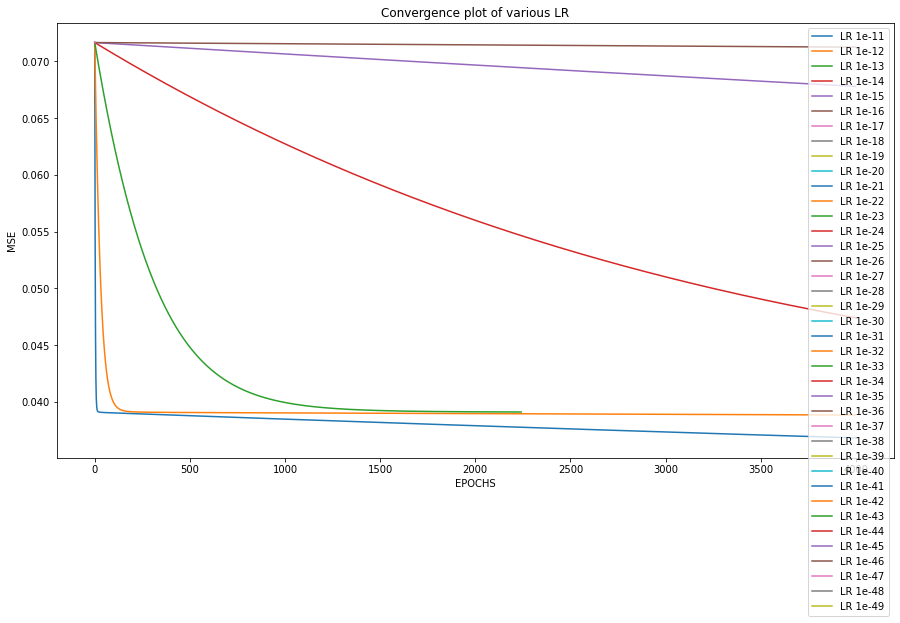

In [ ]:
# Part 2 a. Training and experimenting with non-normalized data.
# Your code here:
from tqdm import tqdm

non_norm_train_data = load_data("IA1_train.csv")
# preprocess training data: don't normalize, don't remove sqft_living15, and save the z scaling mu and sigma values
non_norm_train_data = preprocess_data(non_norm_train_data, False, False, True)

nn_X, nn_y = split_df(non_norm_train_data)

nn_training_losses = []
nn_learning_rates = []
nn_good_weights = []

# Trying various learning rates
for m in tqdm(range(0, 50, 1)):
    lr = np.power(10.0, -m)
    nn_weights, nn_losses, did_diverge = gd_train(nn_X, nn_y, lr, log=False)
    
    if not did_diverge:
        nn_training_losses.append(nn_losses)
        nn_learning_rates.append(lr)
        nn_good_weights.append(nn_weights)

# 1.5 -> 0.00001 diverged
# 1, 1/10, 1/100 -> converge

# print("nn_training_losses", nn_training_losses)
# print('learnnig rates', nn_learning_rates)
# Plot all curves that did not diverge
plot_losses(nn_training_losses, nn_learning_rates)

In [ ]:
# let's get the best LR for now
blr = list(sorted(zip(nn_training_losses, nn_learning_rates), key=lambda x: x[0][-1]))
print([b[1] for b in blr[:2]])

# now we know best range base 10 is roughly around 10^-11 and 10^-12

[1e-11, 1e-12]


In [ ]:
# let's try other LR
nn_training_losses = []
nn_learning_rates = []
nn_good_weights = []

# Trying various learning rates between 10^-10 and 10^-13 with steps of 4*10^-12
for lr in tqdm(np.arange(1e-10, 1e-13, -4e-12)):  # try nonbase10
    #lr = np.power(10.0, -m)
    nn_weights, nn_losses, did_diverge = gd_train(nn_X, nn_y, lr, log=False)
    
    if not did_diverge:
        nn_training_losses.append(nn_losses)
        nn_learning_rates.append(lr)
        nn_good_weights.append(nn_weights)

# print(np.arange(1e-10, 1e-13, -4e-12).shape)

100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


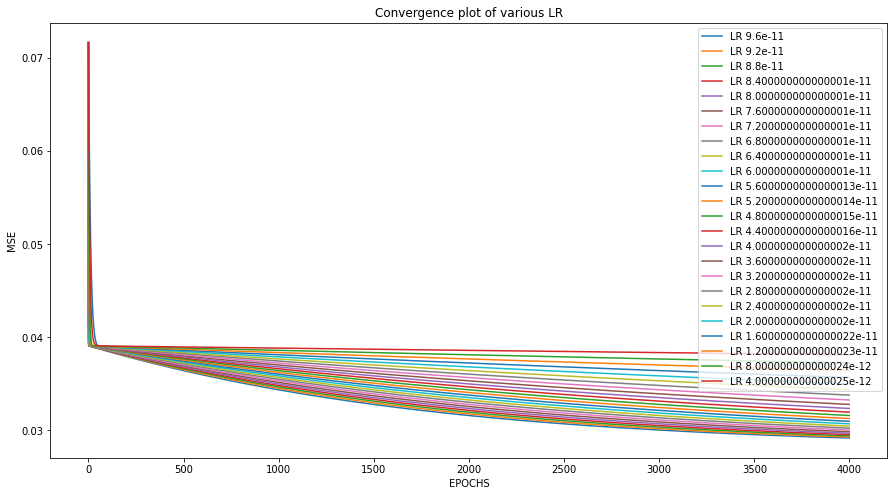

In [ ]:
plot_losses(nn_training_losses, nn_learning_rates)

In [ ]:
# let's see the best learning rates within the refined range
blr = list(sorted(zip(nn_training_losses, nn_learning_rates), key=lambda x: x[0][-1]))
print([b[1] for b in blr[:2]])

# here the best LR range we found was 9.6e-11 and 9.2e-11

[9.6e-11, 9.2e-11]


In [ ]:
# let's try other LR
nn_training_losses = []
nn_learning_rates = []
nn_good_weights = []

# Trying various learning rates between 9.6*10^-111 and 9.2*10^-11 with steps of 2*10^-13
for lr in tqdm(np.arange(9.6e-11, 9.2e-11, -2e-13)):  # try nonbase10
    #lr = np.power(10.0, -m)
    nn_weights, nn_losses, did_diverge = gd_train(nn_X, nn_y, lr, log=False)
    
    if not did_diverge:
        nn_training_losses.append(nn_losses)
        nn_learning_rates.append(lr)
        nn_good_weights.append(nn_weights)

# print(np.arange(9.6e-11, 9.2e-11, -2e-13).shape)

100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


In [ ]:
blr = list(sorted(zip(nn_training_losses, nn_learning_rates, nn_good_weights), key=lambda x: x[0][-1]))
print('\n'.join([('MSE %.4f LR %s' % (b[0][-1], str(b[1]))) for b in blr[:2]]))  # get last MSE for train and their respective LR

# best non-normalized training LR = 9.6e-11 with MSE of 0.0292

MSE 0.0292 LR 9.6e-11
MSE 0.0292 LR 9.580000000000001e-11


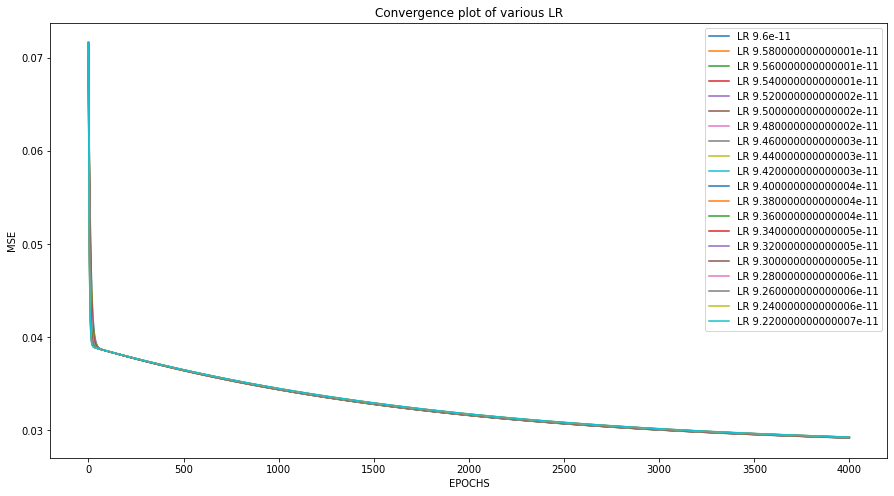

In [ ]:
plot_losses(nn_training_losses, nn_learning_rates)

In [ ]:
#training MSE = MSE 0.0292
# validation MSE

validation_data = load_data("IA1_dev.csv")
# preprocess validation data: don't normalize, don't remove sqft_living15, and use saved mu and sigma values
validation_data = preprocess_data(validation_data, False, False, False)

# mse for not divergent
X, y = split_df(validation_data)

# let's get best weights
w = blr[0][2]

y_hat = predict(X, w)
# calculate MSE
N = X.shape[0]
validation_mse = float(mse(N, y_hat, y))

print("Validation MSE:", validation_mse)

Validation MSE: 0.06469095616316063


In [ ]:
std = list(sorted(zip(X_COLS, w), key=lambda x: abs(float(x[1])), reverse=True))
for col, weight in std:
    if col != "W0":
        print('%s: %f' % (col, float(weight)))

sqft_living: 0.000955
sqft_above: 0.000723
sqft_living15: 0.000588
sqft_basement: 0.000233
zipcode: 0.000009
yr_built: -0.000005
sqft_lot15: -0.000004
age_since_renovated: 0.000002
sqft_lot: 0.000002
grade: 0.000001
day: -0.000001
view: 0.000001
bathrooms: 0.000001
bedrooms: 0.000000
floors: 0.000000
condition: 0.000000
lat: 0.000000
year: 0.000000
waterfront: 0.000000
long: -0.000000
month: -0.000000


In [ ]:
# Part 2b Training with redundant feature removed. 
# Your code here:
from copy import deepcopy

# get rid of the columns
DX_COLS = deepcopy(X_COLS)
DX_COLS.remove('sqft_living15')

100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


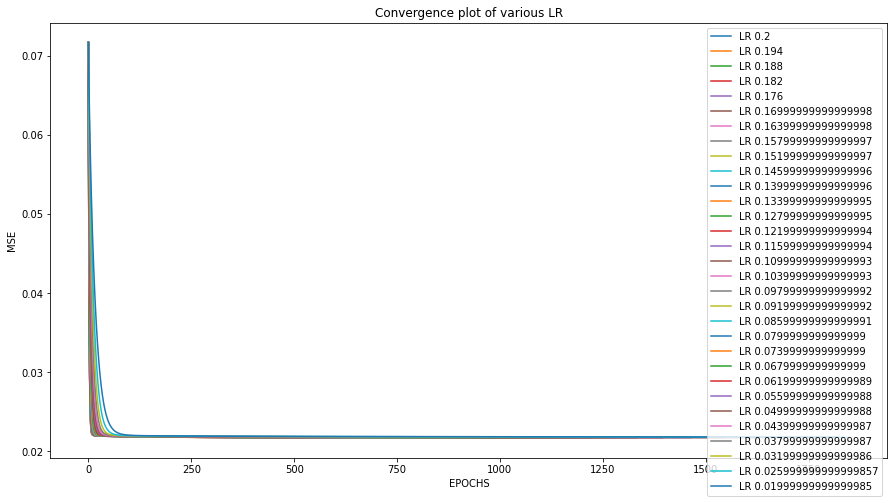

In [ ]:
# preprocess data: normalize, drop sqft_living15, save mu and sigma from training normalization
train_data = load_data("IA1_train.csv")
train_data_wo15 = preprocess_data(train_data, True, True, True)
X, y = split_df(train_data_wo15, use_cols=DX_COLS)  # split using new column list

training_losses_wo15 = []
learning_rates_wo15 = []
good_weights_wo15 = []

# Trying learning rates between 0.2 and 0.02 with step size of 6*10^-3
for lr in tqdm(np.arange(2e-1, 2e-2, -6e-3)):
    weights_wo15, losses_wo15, did_diverge_wo15 = gd_train(X, y, lr, log=False)
    
    # Add to plot data if curve did not diverge
    # and save the weights for validation data
    if not did_diverge:
        training_losses_wo15.append(losses_wo15)
        learning_rates_wo15.append(lr)
        good_weights_wo15.append(weights_wo15)
    
# Plot all curves that did not diverge
plot_losses(training_losses_wo15, learning_rates_wo15)

In [ ]:
blr = list(sorted(zip(training_losses_wo15, learning_rates_wo15, good_weights_wo15), key=lambda x: x[0][-1]))
print('\n'.join([('MSE %f LR %s' % (b[0][-1], str(b[1]))) for b in blr[:2]]))  # get last MSE for train and their respective LR

# best training LR = 0.194 with MSE of 0.021704

MSE 0.021704 LR 0.194
MSE 0.021705 LR 0.188


In [ ]:
validation_data = load_data("IA1_dev.csv")
# preprocess validation data: normalize, drop sqft_living15, and use saved mu and sigma values
validation_data_wo15 = preprocess_data(validation_data, True, True, False)

# mse for not divergent
X, y = split_df(validation_data_wo15, use_cols=DX_COLS)

# let's get best weights
w = blr[0][2]

y_hat = predict(X, w)
# calculate MSE
N = X.shape[0]
validation_mse_wo15 = float(mse(N, y_hat, y))

print("Validation MSE:", validation_mse_wo15)

Validation MSE: 0.0477508983982141


In [ ]:
std = list(sorted(zip(DX_COLS, w), key=lambda x: abs(float(x[1])), reverse=True))
for col, weight in std:
    if col != "W0":
        print('%s: %f' % (col, float(weight)))

waterfront: 3.159181
grade: 1.151494
yr_built: -0.876300
lat: 0.840815
sqft_living: 0.805577
sqft_above: 0.801922
view: 0.488336
bathrooms: 0.332503
long: -0.288834
bedrooms: -0.285387
zipcode: -0.273002
condition: 0.196485
year: 0.173379
sqft_basement: 0.156564
sqft_lot15: -0.096112
age_since_renovated: -0.092434
month: 0.056733
sqft_lot: 0.052744
day: -0.049676
floors: 0.004698
